介绍两个广泛使用的网络，即 门控循环单元 (gated recurrent units, GRU) 和 长短期记忆网络 (long short-term memory, LSTM)。

基于单向隐藏层来扩展循环神经网络架构，现代循环网络经常采用这种扩展。

描述具有多个隐藏层的深层架构，并讨论基于前向和后向循环计算的双向设计。

在各种序列学习问题中，如自动语音识别、文本到语音的转换和机器翻译，输入和输出都是任意长度的序列。 本章中，我们将以机器翻译为例介绍基于循环神经网络的“编码器－解码器”结构和束搜索，并用它们来生成序列。

# GRU
矩阵连续乘积可以导致梯度消失或爆炸。思考一下这种梯度异常在实践中的意义：

我们可能会遇到这样一种情况——早期观测值对预测所有未来观测值具有非常重要的意义。

我们可能会遇到这样的情况——一些标记没有相关的观测值。

我们可能会遇到这样的情况——序列的各个部分之间存在逻辑中断。

解决办法：

    最早的方法是“长-短记忆” ; 
    门控循环单元（gated recurrent unit，GRU）是一个稍微简化的变体，通常提供相当的性能，并且计算的速度明显更快。

## 1、门控隐藏状态
普通的循环神经网络和门控循环单元之间的关键区别在于后者支持隐藏状态的门控（或者说选通）。这意味着有专门的机制来确定何时应该更新隐藏状态，以及何时应该重置隐藏状态。

### 重置门、更新门
重置门（reset gate）和更新门（update gate）。我们把它们设计成 (0,1) 区间中的向量，这样我们就可以进行凸组合。例如，重置门允许我们控制可能还想记住多少以前的状态。同样，更新门将允许我们控制新状态中有多少是旧状态的副本。

图9.1.1 示出了在给定当前时间步的输入和前一时间步隐藏状态的情况下，用于门控循环单元中的重置门和更新门的输入。两个门的输出由具有sigmoid激活函数的两个全连接层给出。
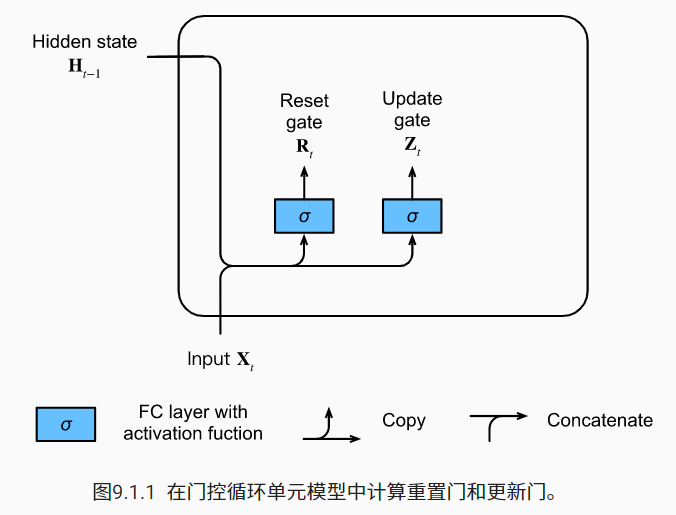

然后，重置门 Rt∈Rn×h 和更新门 Zt∈Rn×h 的计算如下：
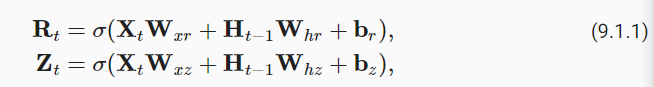
使用sigmoid函数（如:numref:sec_mlp中介绍的）将输入值转换到区间 (0,1) 。

### 候选隐藏状态
将重置门  Rt  与 (8.4.5) 中的常规隐状态更新机制集成，得到在时间步 t 的候选隐藏状态 H~t∈Rn×h :
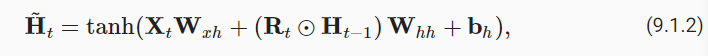

符号 ⊙ 是哈达码乘积（按元素乘积）运算符。

使用tanh非线性激活函数来确保候选隐藏状态中的值保持在区间 (−1,1) 中。

Rt 和 Ht−1 的元素相乘可以减少以往状态的影响。每当重置门 Rt 中的项接近1时，我们恢复一个如:eqref:rnn_h_with_state中的循环神经网络。对于重置门 Rt 中所有接近0的项，候选隐藏状态是以 Xt 作为输入的多层感知机的结果。因此，任何预先存在的隐藏状态都会被重置为默认值。

应用重置门后的计算流程：
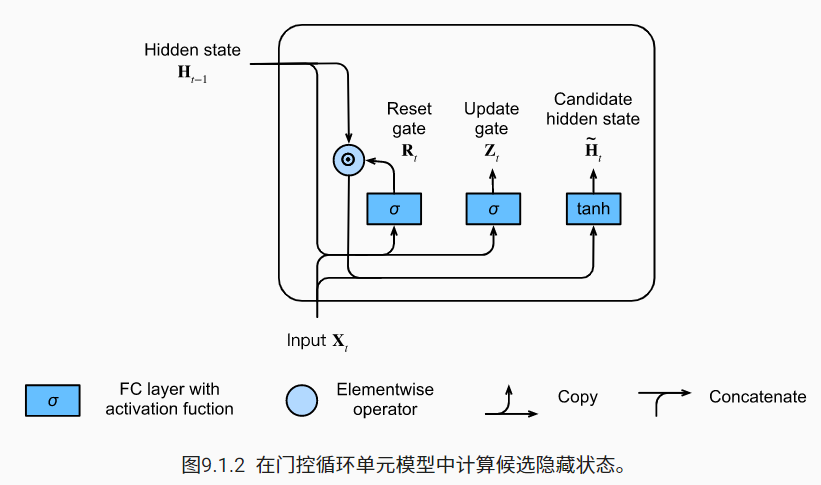

### 隐藏状态
结合更新门 Zt 的效果。这确定新隐藏状态 Ht∈Rn×h 是旧状态 Ht−1 的程度以及新候选状态 H~t 的使用量。

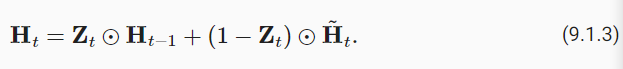
每当更新门 Zt 接近1时，我们只保留旧状态。在这种情况下，来自 Xt 的信息基本上被忽略，有效地跳过了依赖链条中的时间步 t 。相反，当 Zt 接近0时，新隐藏状态 Ht 接近候选隐藏状态 H~t 。

可以帮助我们处理循环神经网络中的消失梯度问题，并更好地捕获具有大时间步长距离的序列的相关性。例如，如果整个子序列的所有时间步的更新门都接近于1，则无论序列的长度如何，在序列起始时间步的旧隐藏状态都将很容易保留并传递到序列结束。

更新门起作用后的计算流：
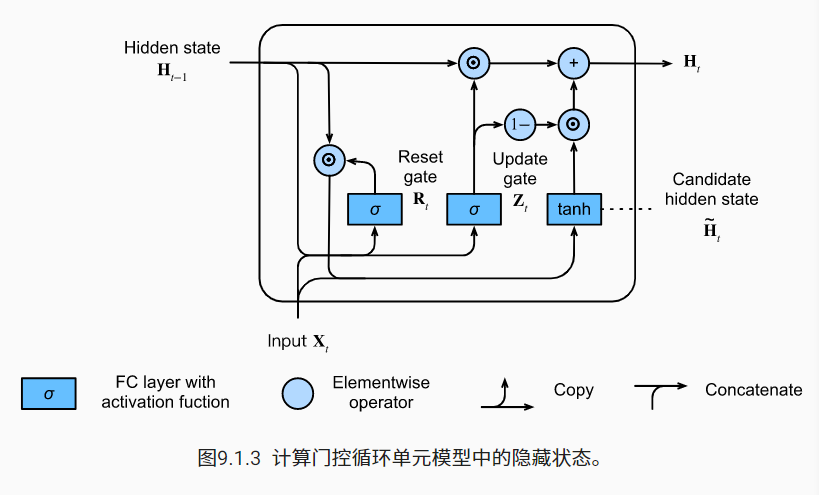

门控循环单元具有以下两个显著特征：

    重置门能够帮助捕获序列中的短期依赖关系。
    更新门能够帮助捕获序列中的长期依赖关系。

## 2、实现

In [2]:
import torch
from torch import nn
from d2l import torch as d2l
import sys
sys.path.append('../../CommonFunctions/tools/')
import common_tools
import sequence_tools

In [3]:
batch_size, num_steps = 32, 35
train_iter, vocab = sequence_tools.load_data_time_machine(batch_size, num_steps)

### 初始化模型参数
标准差为0.01的高斯分布中提取权重，并将偏置项设为0。超参数num_hiddens定义了隐藏单元的数量。我们实例化与更新门、重置门、候选隐藏状态和输出层相关的所有权重和偏置。

In [4]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    
    def three():
        return (normal((num_inputs, num_hiddens)), 
    normal((num_hiddens, num_hiddens)), 
    torch.zeros(num_hiddens, device=device))
    
    W_xz, W_hz, b_z = three() # 更新门参数
    W_xr, W_hr, b_r = three() # 重置门参数
    W_xh, W_hh, b_h = three() # 候选隐藏状态参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

### 定义模型
现在我们将定义隐藏状态初始化函数init_gru_state。函数返回一个值均为零的形状为 (批量大小, 隐藏单元数) 的张量。

In [5]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)

In [6]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

### 训练与预测

困惑度 1.1, 13400.8 标记/秒 cuda:2
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


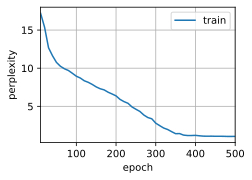

In [9]:
vocab_size, num_hiddens, device = len(vocab), 256, common_tools.try_gpu(2)
num_epochs, lr = 500, 1
model = sequence_tools.RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, gru)
sequence_tools.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## 3、简洁实现

In [13]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = sequence_tools.RNNModel(gru_layer, len(vocab))
model = model.to(device)

In [14]:
model

RNNModel(
  (rnn): GRU(28, 256)
  (linear): Linear(in_features=256, out_features=28, bias=True)
)

困惑度 1.0, 186474.6 标记/秒 cuda:2
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


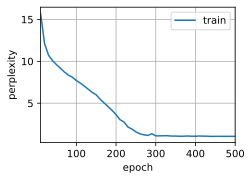

In [15]:
sequence_tools.train_ch8(model, train_iter, vocab, lr, num_epochs, device)